In [192]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import random
import math
import sys
import numpy as np
%matplotlib inline

In [193]:
# Parametros 
TAMANHO_DO_PLANO = 10000
QUANT_OBSTACULOS = 100
RAIO = 100

PONTO_INICIO = (0,0)
PONTO_FIM = (TAMANHO_DO_PLANO,TAMANHO_DO_PLANO)

mapa_obstaculos = []
arestas_globais = []


In [194]:
def encerrar_com_mensagem(ax,mensagem, cor='red'):
    ax.text(0.5, 0.5, mensagem, ha='center', va='center', fontsize=16, color=cor, transform=ax.transAxes)
    plt.draw()
    plt.show(block=True)
    sys.exit()



In [195]:
def calcular_distancia(ponto1, ponto2): 
    return math.sqrt((ponto1[0] - ponto2[0])**2 + (ponto1[1] - ponto2[1])**2) #  é a formula Euclidiana basicamente,  melhor forma pelo que eu vi ( a outra que eu tenti ainda tinha sobreposição na diagonal )



In [196]:
def verifica_intervalo(ponto_inserido,ponto_verifica):
    distancia = calcular_distancia(ponto_inserido,ponto_verifica)
    return ((distancia > (RAIO * 2)) | (distancia < 0))



In [197]:
def calcular_laterais(ponto_centro):
    ponto_cima = (ponto_centro[0] + RAIO,ponto_centro[1])
    ponto_baixo = (ponto_centro[0] - RAIO,ponto_centro[1])
    ponto_direito = (ponto_centro[0] ,ponto_centro[1] + RAIO)
    ponto_esquerdo = (ponto_centro[0] ,ponto_centro[1] - RAIO)
    return  ponto_cima,ponto_baixo,ponto_direito,ponto_esquerdo



In [198]:
def calcular_distancia_reta(r_a, r_b, r_c, c_x, c_y):
    cima = abs((r_a * c_x) + (r_b * c_y) + r_c)
    baixo = math.sqrt((r_a ** 2) + (r_b ** 2))
    return cima / baixo




In [199]:
def gerar_obstaculo_existente(novo_centro):
    if calcular_distancia(novo_centro, PONTO_INICIO) < RAIO:
        return True
    if calcular_distancia(novo_centro, PONTO_FIM) < RAIO:
        return True
    if any(not verifica_intervalo(novo_centro, obstaculo[0]) for obstaculo in mapa_obstaculos):
        return True
    return False



In [200]:
def posicionar_obstaculos():
    for _ in range(QUANT_OBSTACULOS):
        tentativas = 0
        while True:
            tentativas += 1
            if tentativas >= 1000:
                print(f"Não há mais espaço! Foram posicionados {len(mapa_obstaculos)} obstáculos.")
                return  # Sai do posicionamento, mas mantém os já posicionados
            x = random.uniform(RAIO, TAMANHO_DO_PLANO - RAIO)
            y = random.uniform(RAIO, TAMANHO_DO_PLANO - RAIO)
            novo_centro = (x, y)
            if gerar_obstaculo_existente(novo_centro):
                continue
            mapa_obstaculos.append((novo_centro, calcular_laterais(novo_centro)))
            break



In [201]:
def reta_livre_de_obstaculos(A, B, mapa_obstaculos, raio):
    for obstaculo in mapa_obstaculos:
        centro = obstaculo[0]
        laterais = obstaculo[1]
        
        # 1. Se A e B são laterais do mesmo círculo, bloqueia
        if A in laterais and B in laterais:
            return False
            
        # 2. Coeficientes da reta AB: ax + by + c = 0
        r_a = B[1] - A[1]
        r_b = A[0] - B[0] 
        r_c = B[1] * (B[0] - A[0]) - (B[1] - A[1]) * B[0]

        # 3. Distância do centro do círculo à reta
        dist_reta = calcular_distancia_reta(r_a, r_b, r_c, centro[0], centro[1])
        
        # 4. Se a distância for menor que o raio, há interseção
        if dist_reta < raio:
            # 5. Verifica se a interseção está no segmento AB (não na reta infinita)
            # Calcula o ponto mais próximo do centro na reta AB
            denominador = r_a * r_a + r_b * r_b
            if denominador != 0:
                px = (r_b * (r_b * centro[0] - r_a * centro[1]) - r_a * r_c) / denominador
                py = (r_a * (-r_b * centro[0] + r_a * centro[1]) - r_b * r_c) / denominador
                
                # Verifica se o ponto projetado está dentro do segmento AB
                min_x, max_x = min(A[0], B[0]), max(A[0], B[0])
                min_y, max_y = min(A[1], B[1]), max(A[1], B[1])
                
                if min_x <= px <= max_x and min_y <= py <= max_y:
                    return False
    return True



In [202]:
def gerar_arestas():
    # Gera todas as arestas válidas e as adiciona aos obstáculos
    # Formato: [ponto_centro, [pontos_laterais], [arestas]]
    
    # Primeiro, inicializa a lista de arestas para cada obstáculo
    for i, obstaculo in enumerate(mapa_obstaculos):
        if len(obstaculo) == 2:  # Se ainda não tem arestas
            mapa_obstaculos[i] = (obstaculo[0], obstaculo[1], [])
    
    # Arestas do início aos pontos laterais
    for obstaculo in mapa_obstaculos:
        for ponto_lateral in obstaculo[1]:
            if reta_livre_de_obstaculos(PONTO_INICIO, ponto_lateral, mapa_obstaculos, RAIO):
                aresta = (PONTO_INICIO, ponto_lateral, 'blue', '--')
                arestas_globais.append(aresta)
    
    # Arestas do fim aos pontos laterais
    for obstaculo in mapa_obstaculos:
        for ponto_lateral in obstaculo[1]:
            if reta_livre_de_obstaculos(PONTO_FIM, ponto_lateral, mapa_obstaculos, RAIO):
                aresta = (PONTO_FIM, ponto_lateral, 'red', '--')
                arestas_globais.append(aresta)
    
    # Arestas entre pontos laterais (evita duplicação)
    for i, obstaculo_a in enumerate(mapa_obstaculos):
        for j, obstaculo_b in enumerate(mapa_obstaculos):
            if i >= j:  # Evita duplicação (só processa i < j)
                continue
            for ponto_lateral_a in obstaculo_a[1]:
                for ponto_lateral_b in obstaculo_b[1]:
                    if reta_livre_de_obstaculos(ponto_lateral_a, ponto_lateral_b, mapa_obstaculos, RAIO):
                        aresta = (ponto_lateral_a, ponto_lateral_b, 'green', '-')
                        # Adiciona à lista do primeiro obstáculo
                        mapa_obstaculos[i] = (mapa_obstaculos[i][0], mapa_obstaculos[i][1], mapa_obstaculos[i][2] + [aresta])
    
    # Verifica caminho direto início-fim
    if reta_livre_de_obstaculos(PONTO_INICIO, PONTO_FIM, mapa_obstaculos, RAIO):
        aresta = (PONTO_INICIO, PONTO_FIM, 'purple', '-')
        arestas_globais.append(aresta)



In [203]:
def caminho_ini_fim():
    """
        Percorre o mapa de obstaculos entre os pontos dos obstaculos, mas caso não tenha obstaculos, faz a linha direta, utilizando o conceito de busca por profundidade    
    """
    
    if len(mapa_obstaculos) == 0:
        return [PONTO_INICIO, PONTO_FIM]
    
    # Implementação de busca por profundidade (DFS) para encontrar um caminho
    stack = [(PONTO_INICIO, [PONTO_INICIO])]
    visited = set()
    
    while stack:
        current, path = stack.pop()
        
        if current == PONTO_FIM:
            return path
        
        if current in visited:
            continue
        visited.add(current)
        
        # Adiciona vizinhos (pontos laterais dos obstáculos conectados)
        for obstaculo in mapa_obstaculos:
            for ponto_lateral in obstaculo[1]:
                if reta_livre_de_obstaculos(current, ponto_lateral, mapa_obstaculos, RAIO):
                    stack.append((ponto_lateral, path + [ponto_lateral]))
    
    return None  # Se não encontrar caminho




In [204]:
def inicializar_plot():
    fig, ax = plt.subplots()
    ax.set_xlim(0, TAMANHO_DO_PLANO)
    ax.set_ylim(0, TAMANHO_DO_PLANO)
    ax.set_aspect('equal')
    ax.grid(color='gray', linestyle='--', alpha=0.3)
    ax.axhline(0, color='white', linewidth=0.5)
    ax.axvline(0, color='white', linewidth=0.5)
    ax.plot(PONTO_INICIO[0], PONTO_INICIO[1], 'go', markersize=10, label='Início')
    ax.plot(PONTO_FIM[0], PONTO_FIM[1], 'ro', markersize=10, label='Fim')
    
    # Opção 2: Colocar fora da figura (à direita)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), frameon=True)
    plt.tight_layout()  # Ajusta automaticamente para não cortar
    
    return fig, ax


In [205]:
def plotar_arestas(ax):
    # Plota arestas globais (início/fim)
    for aresta in arestas_globais:
        ponto_a, ponto_b, cor, estilo = aresta
        ax.plot([ponto_a[0], ponto_b[0]], [ponto_a[1], ponto_b[1]], 
                color=cor, linestyle=estilo)
    
    # Plota arestas dos obstáculos
    for obstaculo in mapa_obstaculos:
        if len(obstaculo) > 2:  # Se tem arestas
            for aresta in obstaculo[2]:
                ponto_a, ponto_b, cor, estilo = aresta
                ax.plot([ponto_a[0], ponto_b[0]], [ponto_a[1], ponto_b[1]], 
                        color=cor, linestyle=estilo)

In [206]:
def plotar_obstaculos():
    # Inicializa o plot com início e fim
    _,ax = inicializar_plot()
    
    # Desenha todos os obstáculos
    for obstaculo in mapa_obstaculos:
        circulo = plt.Circle(obstaculo[0], RAIO, color="gray", alpha=0.7)
        for ponto in obstaculo[1]:
            ax.plot(ponto[0], ponto[1], 'o', markersize=2, color="black")
        ax.add_patch(circulo)
    
    plotar_arestas(ax)
    
    plt.title('Mapa de Obstáculos')
    plt.show()



Posicionados 100 obstáculos


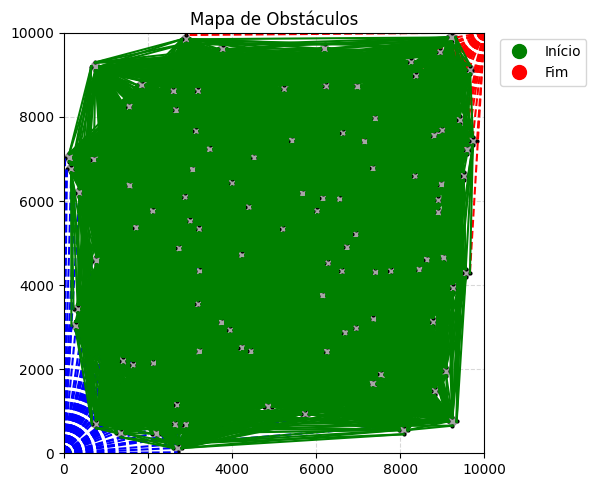

In [207]:
def main():
    posicionar_obstaculos()
    gerar_arestas()
    print(f"Posicionados {len(mapa_obstaculos)} obstáculos")
    plotar_obstaculos()

if __name__ == "__main__":
    main()

In [208]:
mapa_obstaculos[0]

((180.12550277192457, 6761.730544837088),
 ((280.1255027719246, 6761.730544837088),
  (80.12550277192457, 6761.730544837088),
  (180.12550277192457, 6861.730544837088),
  (180.12550277192457, 6661.730544837088)),
 [((280.1255027719246, 6761.730544837088),
   (657.3320596283246, 9191.681613183542),
   'green',
   '-'),
  ((280.1255027719246, 6761.730544837088),
   (757.3320596283246, 9091.681613183542),
   'green',
   '-'),
  ((280.1255027719246, 6761.730544837088),
   (2551.172181221742, 688.6485488597264),
   'green',
   '-'),
  ((180.12550277192457, 6861.730544837088),
   (2574.136120617911, 8151.003467179453),
   'green',
   '-'),
  ((180.12550277192457, 6861.730544837088),
   (2674.136120617911, 8051.003467179453),
   'green',
   '-'),
  ((280.1255027719246, 6761.730544837088),
   (3904.108005829672, 6424.029397853868),
   'green',
   '-'),
  ((280.1255027719246, 6761.730544837088),
   (4004.108005829672, 6524.029397853868),
   'green',
   '-'),
  ((180.12550277192457, 6661.7305448

In [209]:
mapa_obstaculos[0]

((180.12550277192457, 6761.730544837088),
 ((280.1255027719246, 6761.730544837088),
  (80.12550277192457, 6761.730544837088),
  (180.12550277192457, 6861.730544837088),
  (180.12550277192457, 6661.730544837088)),
 [((280.1255027719246, 6761.730544837088),
   (657.3320596283246, 9191.681613183542),
   'green',
   '-'),
  ((280.1255027719246, 6761.730544837088),
   (757.3320596283246, 9091.681613183542),
   'green',
   '-'),
  ((280.1255027719246, 6761.730544837088),
   (2551.172181221742, 688.6485488597264),
   'green',
   '-'),
  ((180.12550277192457, 6861.730544837088),
   (2574.136120617911, 8151.003467179453),
   'green',
   '-'),
  ((180.12550277192457, 6861.730544837088),
   (2674.136120617911, 8051.003467179453),
   'green',
   '-'),
  ((280.1255027719246, 6761.730544837088),
   (3904.108005829672, 6424.029397853868),
   'green',
   '-'),
  ((280.1255027719246, 6761.730544837088),
   (4004.108005829672, 6524.029397853868),
   'green',
   '-'),
  ((180.12550277192457, 6661.7305448

In [210]:
arestas_globais

[((0, 0), (80.12550277192457, 6761.730544837088), 'blue', '--'),
 ((0, 0), (180.12550277192457, 6661.730544837088), 'blue', '--'),
 ((0, 0), (4352.334061747878, 2422.704525519946), 'blue', '--'),
 ((0, 0), (4452.334061747878, 2322.704525519946), 'blue', '--'),
 ((0, 0), (1553.2918038754142, 2104.3049620938405), 'blue', '--'),
 ((0, 0), (1653.2918038754142, 2004.3049620938405), 'blue', '--'),
 ((0, 0), (8451.724511392025, 4267.343935996888), 'blue', '--'),
 ((0, 0), (2551.172181221742, 688.6485488597264), 'blue', '--'),
 ((0, 0), (2107.0286279331176, 466.6934138207232), 'blue', '--'),
 ((0, 0), (2207.0286279331176, 366.6934138207232), 'blue', '--'),
 ((0, 0), (3230.0332441794303, 2321.348309285111), 'blue', '--'),
 ((0, 0), (6533.707913208874, 7609.021416529167), 'blue', '--'),
 ((0, 0), (675.0010329685381, 693.8276250930415), 'blue', '--'),
 ((0, 0), (775.0010329685381, 593.8276250930415), 'blue', '--'),
 ((0, 0), (2016.9883493682046, 5757.73964636006), 'blue', '--'),
 ((0, 0), (2116.9

In [211]:
dict_caminhos = {}

# Inicializa todos os pontos laterais no dicionário
for obstaculo in mapa_obstaculos:
    for ponto_lateral in obstaculo[1]:
        dict_caminhos[ponto_lateral] = []

# Adiciona PONTO_INICIO e PONTO_FIM ao dicionário
dict_caminhos[PONTO_INICIO] = []
dict_caminhos[PONTO_FIM] = []

# Processa arestas dos obstáculos (conexões entre pontos laterais de obstáculos diferentes)
for obstaculo in mapa_obstaculos:
    if len(obstaculo) > 2:  # Se tem arestas
        for aresta in obstaculo[2]:
            ponto_a, ponto_b = aresta[0], aresta[1]
            # Adiciona conexão bidirecional
            if ponto_a in dict_caminhos:
                dict_caminhos[ponto_a].append(ponto_b)
            if ponto_b in dict_caminhos:
                dict_caminhos[ponto_b].append(ponto_a)

# Processa arestas globais (conexões com PONTO_INICIO e PONTO_FIM)
for aresta in arestas_globais:
    ponto_a, ponto_b = aresta[0], aresta[1]
    # Adiciona conexão bidirecional
    if ponto_a in dict_caminhos and ponto_b in dict_caminhos:
        dict_caminhos[ponto_a].append(ponto_b)
        dict_caminhos[ponto_b].append(ponto_a)


In [212]:
for obstaculo in mapa_obstaculos:
    ponto_cima,ponto_baixo,ponto_direito,ponto_esquerdo = obstaculo[1]
    dict_caminhos[ponto_direito].append(ponto_cima)
    dict_caminhos[ponto_cima].append(ponto_esquerdo)
    dict_caminhos[ponto_esquerdo].append(ponto_baixo)
    dict_caminhos[ponto_baixo].append(ponto_direito)

In [213]:
dict_caminhos

{(280.1255027719246,
  6761.730544837088): [(657.3320596283246,
   9191.681613183542), (757.3320596283246, 9091.681613183542), (2551.172181221742,
   688.6485488597264), (3904.108005829672,
   6424.029397853868), (4004.108005829672, 6524.029397853868), (3130.0332441794303,
   2421.348309285111), (3230.0332441794303,
   2521.348309285111), (8879.94722058866, 6386.73417942158), (615.7962451646612,
   6978.034332432924), (715.7962451646612,
   6878.034332432924), (6588.237935956231, 2866.662419266828), (6259.908719374259,
   2516.8159475199923), (2016.9883493682046,
   5757.73964636006), (2116.9883493682046, 5857.73964636006), (4401.289506709799,
   5947.49807759447), (3370.9786312487327,
   7228.261253251053), (3470.9786312487327, 7128.261253251053), (3131.2236535584357,
   4334.060644318186), (2640.6406223827744,
   4867.8816203228125), (2740.6406223827744, 4967.8816203228125), (5428.174686635507,
   7332.756167496884), (2609.3866001520846,
   123.46025896130234), (2709.3866001520846, 2

In [214]:
def encontrar_caminho_dfs(ponto_inicial, ponto_final):
    """
    Encontra um caminho usando busca em profundidade (DFS) com controle de visitados
    """
    stack = [(ponto_inicial, [ponto_inicial])]
    visited = set()
    
    while stack:
        current, path = stack.pop()
        
        if current == ponto_final:
            return path
        
        if current in visited:
            continue
        
        visited.add(current)
        
        # Adiciona vizinhos à pilha
        for neighbor in dict_caminhos.get(current, []):
            if neighbor not in visited:
                stack.append((neighbor, path + [neighbor]))
    
    return None

# Encontra o caminho
caminho_encontrado = encontrar_caminho_dfs(PONTO_INICIO, PONTO_FIM)
if caminho_encontrado:
    print(f"Caminho encontrado com {len(caminho_encontrado)} pontos:")
    for i, ponto in enumerate(caminho_encontrado):
        print(f"  {i}: {ponto}")
else:
    print("Nenhum caminho encontrado!")

Caminho encontrado com 110 pontos:
  0: (0, 0)
  1: (1413.5608971983595, 2096.5747254337953)
  2: (1313.5608971983595, 2196.5747254337953)
  3: (1413.5608971983595, 2296.5747254337953)
  4: (1513.5608971983595, 2196.5747254337953)
  5: (8271.817440979243, 8971.212508443132)
  6: (8371.817440979243, 9071.212508443132)
  7: (8471.817440979243, 8971.212508443132)
  8: (8371.817440979243, 8871.212508443132)
  9: (1670.0171917238183, 6360.123773244574)
  10: (1570.0171917238183, 6260.123773244574)
  11: (1470.0171917238183, 6360.123773244574)
  12: (1570.0171917238183, 6460.123773244574)
  13: (3196.287436102961, 8515.19335360126)
  14: (3096.287436102961, 8615.19335360126)
  15: (3196.287436102961, 8715.19335360126)
  16: (3296.287436102961, 8615.19335360126)
  17: (5680.049442404256, 6275.249093517576)
  18: (5780.049442404256, 6175.249093517576)
  19: (5680.049442404256, 6075.249093517576)
  20: (5580.049442404256, 6175.249093517576)
  21: (2234.341001070301, 2143.991961877049)
  22: (21

In [215]:
def ponto_mesmo_centroide(ponto1, ponto2):
    for obstaculo in mapa_obstaculos:
        centro, laterais = obstaculo[0], obstaculo[1]
        if ponto1 in laterais and ponto2 in laterais:
            return True, centro
    return False, None


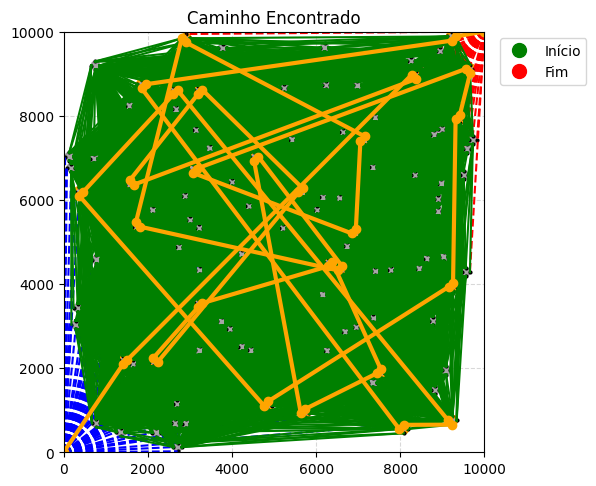

In [216]:
fig, ax = inicializar_plot()

# Plota obstáculos e arestas
for obstaculo in mapa_obstaculos:
    circulo = plt.Circle(obstaculo[0], RAIO, color="gray", alpha=0.7)
    for ponto in obstaculo[1]:
        ax.plot(ponto[0], ponto[1], 'o', markersize=2, color="black")
    ax.add_patch(circulo)
plotar_arestas(ax)

# Plota o caminho encontrado
if caminho_encontrado:
    for i in range(len(caminho_encontrado) - 1):
        ponto1 = caminho_encontrado[i]
        ponto2 = caminho_encontrado[i + 1]
        
        mesmo_centro, centroid = ponto_mesmo_centroide(ponto1, ponto2)
        # print(mesmo_centro, centroid)
        if mesmo_centro:
            # Desenha arco entre pontos do mesmo obstáculo
            angulo1 = np.degrees(np.arctan2(ponto1[1] - centroid[1], ponto1[0] - centroid[0]))
            angulo2 = np.degrees(np.arctan2(ponto2[1] - centroid[1], ponto2[0] - centroid[0]))
            arco = Arc(centroid, width=2*RAIO, height=2*RAIO, theta1=angulo1, theta2=angulo2, color="orange", linewidth=2)
            ax.add_patch(arco)
        else:
            # Desenha linha reta entre pontos
            ax.plot([ponto1[0], ponto2[0]], [ponto1[1], ponto2[1]], 
                   color='orange', linewidth=3, marker='o')
    
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), frameon=True)

plt.title('Caminho Encontrado')
plt.show()
